In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0-dev20200315
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
pandas 1.0.3
sklearn 0.22.2.post1
tensorflow 2.2.0-dev20200315
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:

from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7) # test_size=0.25(默认)，可以通过                                   
                                                # 这个改变比例
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)
print(x_train.shape[1:])

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)
(8,)


In [4]:
# 归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [5]:
# RandomizedSearchCV
# 1.转化为sklearn的model
# 2.定义参数集合
# 3.搜索参数
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
              input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers-1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=15, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train, epochs=100,
                 validation_data =(x_valid_scaled, y_valid),
                  callbacks = callbacks
                 )


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
317/363 [=========================>....] - ETA: 0s - loss: 1.4331WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023818308488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output

Epoch 62/100
363/363 [==============================] - 0s 876us/step - loss: 0.3552 - val_loss: 0.3629
Epoch 63/100
363/363 [==============================] - 0s 887us/step - loss: 0.3554 - val_loss: 0.3632
Epoch 64/100
363/363 [==============================] - 0s 885us/step - loss: 0.3531 - val_loss: 0.3612
Epoch 65/100
363/363 [==============================] - 0s 874us/step - loss: 0.3532 - val_loss: 0.3643
Epoch 66/100
363/363 [==============================] - 0s 885us/step - loss: 0.3591 - val_loss: 0.3682
Epoch 67/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3618 - val_loss: 0.3597
Epoch 68/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3509 - val_loss: 0.3589
Epoch 69/100
363/363 [==============================] - 0s 926us/step - loss: 0.3499 - val_loss: 0.3605
Epoch 70/100
363/363 [==============================] - 0s 923us/step - loss: 0.3494 - val_loss: 0.3598
Epoch 71/100
363/363 [==============================] - 0s 909us/ste

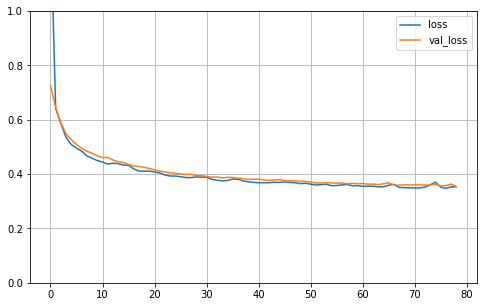

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [16]:
# 2.定义参数集合
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a))  a <= x <= b

param_distribution={
    "hidden_layers":[1,2,3,4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2)
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv= RandomizedSearchCV(sklearn_model, 
                                    param_distribution,
                                    n_iter=10,
                                    n_jobs =1)
random_search_cv.fit(x_train_scaled, y_train, epochs=100,
                    validation_data= (x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
245/291 [========================>.....] - ETA: 0s - loss: 1.6777WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000238198D9A60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output

Epoch 63/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3140 - val_loss: 0.3335
Epoch 64/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3143 - val_loss: 0.3310
Epoch 65/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3124 - val_loss: 0.3344
Epoch 66/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3129 - val_loss: 0.3291
Epoch 67/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3108 - val_loss: 0.3294
Epoch 68/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3104 - val_loss: 0.3327
Epoch 69/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3099 - val_loss: 0.3285
Epoch 70/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3093 - val_loss: 0.3272
Epoch 71/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3090 - val_loss: 0.3284
Epoch 72/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3088

291/291 [==============================] - 0s 1ms/step - loss: 0.3220 - val_loss: 0.3511
Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3211 - val_loss: 0.3475
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3198 - val_loss: 0.3459
Epoch 48/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3194 - val_loss: 0.3461
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3182 - val_loss: 0.3456
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3170 - val_loss: 0.3498
Epoch 51/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3153 - val_loss: 0.3552
Epoch 52/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3147 - val_loss: 0.3435
Epoch 53/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3143 - val_loss: 0.3414
Epoch 54/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3127 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.3529 - val_loss: 0.3713
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3504 - val_loss: 0.3709
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3484 - val_loss: 0.3669
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3473 - val_loss: 0.3680
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3454 - val_loss: 0.3658
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3435 - val_loss: 0.3652
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3431 - val_loss: 0.3638
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3411 - val_loss: 0.3621
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3394 - val_loss: 0.3591
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3377 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.5029 - val_loss: 0.5264
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4756 - val_loss: 0.5033
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4603 - val_loss: 0.4843
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4427 - val_loss: 0.4694
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4311 - val_loss: 0.4581
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4221 - val_loss: 0.4489
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4140 - val_loss: 0.4399
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4067 - val_loss: 0.4316
Epoch 14/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4033 - val_loss: 0.4259
Epoch 15/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3953 - val_loss: 0.4

Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7388 - val_loss: 0.7127
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6306 - val_loss: 0.6593
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5872 - val_loss: 0.6178
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5520 - val_loss: 0.5832
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5252 - val_loss: 0.5591
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5039 - val_loss: 0.5345
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4847 - val_loss: 0.5129
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4699 - val_loss: 0.4974
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4562 - val_loss: 0.4832
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4444 - val_l

284/291 [============================>.] - ETA: 0s - loss: 2.9669WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002381BA5E7B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
291/291 [==============================] - 0s 1ms/step - loss: 2.9268 - val_loss: 1.5809
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.2021

Epoch 72/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3804 - val_loss: 0.3927
Epoch 73/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3792 - val_loss: 0.3917
Epoch 74/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3782 - val_loss: 0.3906
Epoch 75/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3770 - val_loss: 0.3900
Epoch 76/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3762 - val_loss: 0.3897
Epoch 77/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3753 - val_loss: 0.3880
Epoch 78/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3752 - val_loss: 0.3875
Epoch 79/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3743 - val_loss: 0.3867
Epoch 80/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3726 - val_loss: 0.3862
Epoch 81/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3719

291/291 [==============================] - 0s 1ms/step - loss: 0.4482 - val_loss: 0.4823
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4437 - val_loss: 0.4791
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4419 - val_loss: 0.4749
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4379 - val_loss: 0.4733
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4348 - val_loss: 0.4693
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4315 - val_loss: 0.4677
Epoch 42/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4312 - val_loss: 0.4658
Epoch 43/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4276 - val_loss: 0.4615
Epoch 44/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4254 - val_loss: 0.4589
Epoch 45/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4237 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 3.1422 - val_loss: 1.7336
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.2739 - val_loss: 1.0794
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.9394 - val_loss: 0.8832
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8060 - val_loss: 0.7972
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7359 - val_loss: 0.7495
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6965 - val_loss: 0.7188
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6679 - val_loss: 0.6961
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6434 - val_loss: 0.6784
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6261 - val_loss: 0.6635
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6152 - val_loss: 0.6500
E

291/291 [==============================] - 0s 1ms/step - loss: 0.3861 - val_loss: 0.4033
Epoch 82/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3859 - val_loss: 0.4025
Epoch 83/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3844 - val_loss: 0.4020
Epoch 84/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3832 - val_loss: 0.4004
Epoch 85/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3823 - val_loss: 0.3996
Epoch 86/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3822 - val_loss: 0.3984
Epoch 87/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3806 - val_loss: 0.3979
Epoch 88/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3828 - val_loss: 0.3969
Epoch 89/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3791 - val_loss: 0.3959
Epoch 90/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3780 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.3857 - val_loss: 0.4120
Epoch 43/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3837 - val_loss: 0.4095
Epoch 44/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3823 - val_loss: 0.4080
Epoch 45/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3810 - val_loss: 0.4058
Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3803 - val_loss: 0.4043
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3781 - val_loss: 0.4037
Epoch 48/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3778 - val_loss: 0.4024
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3757 - val_loss: 0.4008
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3747 - val_loss: 0.4004
Epoch 51/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3736 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.4817 - val_loss: 0.5184
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4751 - val_loss: 0.5121
Epoch 20/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4703 - val_loss: 0.5058
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4648 - val_loss: 0.5002
Epoch 22/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4624 - val_loss: 0.4942
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4555 - val_loss: 0.4892
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4508 - val_loss: 0.4845
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4469 - val_loss: 0.4801
Epoch 26/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4443 - val_loss: 0.4756
Epoch 27/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4424 - val_loss: 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
264/291 [==========================>...] - ETA: 0s - loss: 1.5743WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000238183A0268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad

291/291 [==============================] - 0s 942us/step - loss: 0.3618 - val_loss: 0.3714
Epoch 67/100
291/291 [==============================] - 0s 925us/step - loss: 0.3611 - val_loss: 0.3695
Epoch 68/100
291/291 [==============================] - 0s 922us/step - loss: 0.3606 - val_loss: 0.3710
Epoch 69/100
291/291 [==============================] - 0s 925us/step - loss: 0.3616 - val_loss: 0.3695
Epoch 70/100
291/291 [==============================] - 0s 925us/step - loss: 0.3594 - val_loss: 0.3697
Epoch 71/100
73/73 [==============================] - 0s 520us/step - loss: 0.3426
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

291/291 [==============================] - 0s 936us/step - loss: 0.3690 - val_loss: 0.3860
Epoch 56/100
291/291 [==============================] - 0s 908us/step - loss: 0.3664 - val_loss: 0.3826
Epoch 57/100
291/291 [==============================] - 0s 870us/step - loss: 0.3655 - val_loss: 0.3845
Epoch 58/100
291/291 [==============================] - 0s 874us/step - loss: 0.3659 - val_loss: 0.3822
Epoch 59/100
291/291 [==============================] - 0s 881us/step - loss: 0.3652 - val_loss: 0.3826
Epoch 60/100
291/291 [==============================] - 0s 864us/step - loss: 0.3639 - val_loss: 0.3816
Epoch 61/100
291/291 [==============================] - 0s 871us/step - loss: 0.3626 - val_loss: 0.3789
Epoch 62/100
291/291 [==============================] - 0s 867us/step - loss: 0.3632 - val_loss: 0.3838
Epoch 63/100
291/291 [==============================] - 0s 867us/step - loss: 0.3619 - val_loss: 0.3789
Epoch 64/100
291/291 [==============================] - 0s 870us/step - loss:

291/291 [==============================] - 0s 891us/step - loss: 0.3696 - val_loss: 0.3943
Epoch 45/100
291/291 [==============================] - 0s 891us/step - loss: 0.3662 - val_loss: 0.3841
Epoch 46/100
291/291 [==============================] - 0s 915us/step - loss: 0.3653 - val_loss: 0.3812
Epoch 47/100
291/291 [==============================] - 0s 932us/step - loss: 0.3654 - val_loss: 0.3835
Epoch 48/100
291/291 [==============================] - 0s 908us/step - loss: 0.3655 - val_loss: 0.3812
Epoch 49/100
291/291 [==============================] - 0s 881us/step - loss: 0.3639 - val_loss: 0.3797
Epoch 50/100
291/291 [==============================] - 0s 881us/step - loss: 0.3635 - val_loss: 0.3766
Epoch 51/100
291/291 [==============================] - 0s 901us/step - loss: 0.3621 - val_loss: 0.3772
Epoch 52/100
291/291 [==============================] - 0s 929us/step - loss: 0.3618 - val_loss: 0.3756
Epoch 53/100
291/291 [==============================] - 0s 891us/step - loss:

291/291 [==============================] - 0s 898us/step - loss: 0.3913 - val_loss: 0.4141
Epoch 34/100
291/291 [==============================] - 0s 877us/step - loss: 0.3896 - val_loss: 0.4139
Epoch 35/100
291/291 [==============================] - 0s 891us/step - loss: 0.3882 - val_loss: 0.4113
Epoch 36/100
291/291 [==============================] - 0s 932us/step - loss: 0.3874 - val_loss: 0.4090
Epoch 37/100
291/291 [==============================] - 0s 942us/step - loss: 0.3867 - val_loss: 0.4093
Epoch 38/100
291/291 [==============================] - 0s 946us/step - loss: 0.3850 - val_loss: 0.4066
Epoch 39/100
291/291 [==============================] - 0s 929us/step - loss: 0.3825 - val_loss: 0.4057
Epoch 40/100
291/291 [==============================] - 0s 898us/step - loss: 0.3824 - val_loss: 0.4066
Epoch 41/100
291/291 [==============================] - 0s 922us/step - loss: 0.3815 - val_loss: 0.4017
Epoch 42/100
291/291 [==============================] - 0s 884us/step - loss:

291/291 [==============================] - 0s 881us/step - loss: 0.3958 - val_loss: 0.4193
Epoch 30/100
291/291 [==============================] - 0s 901us/step - loss: 0.3929 - val_loss: 0.4192
Epoch 31/100
291/291 [==============================] - 0s 939us/step - loss: 0.3878 - val_loss: 0.4136
Epoch 32/100
291/291 [==============================] - 0s 881us/step - loss: 0.3852 - val_loss: 0.4211
Epoch 33/100
291/291 [==============================] - 0s 898us/step - loss: 0.3927 - val_loss: 0.4195
Epoch 34/100
291/291 [==============================] - 0s 953us/step - loss: 0.3873 - val_loss: 0.4129
Epoch 35/100
291/291 [==============================] - 0s 963us/step - loss: 0.3860 - val_loss: 0.4095
Epoch 36/100
291/291 [==============================] - 0s 953us/step - loss: 0.3845 - val_loss: 0.4096
Epoch 37/100
291/291 [==============================] - 0s 884us/step - loss: 0.3828 - val_loss: 0.4085
Epoch 38/100
291/291 [==============================] - 0s 898us/step - loss:

291/291 [==============================] - 0s 936us/step - loss: 0.6240 - val_loss: 0.6714
Epoch 20/100
291/291 [==============================] - 0s 949us/step - loss: 0.6194 - val_loss: 0.6633
Epoch 21/100
291/291 [==============================] - 0s 905us/step - loss: 0.6095 - val_loss: 0.6557
Epoch 22/100
291/291 [==============================] - 0s 881us/step - loss: 0.6034 - val_loss: 0.6486
Epoch 23/100
291/291 [==============================] - 0s 932us/step - loss: 0.5964 - val_loss: 0.6416
Epoch 24/100
291/291 [==============================] - 0s 939us/step - loss: 0.5909 - val_loss: 0.6350
Epoch 25/100
291/291 [==============================] - 0s 939us/step - loss: 0.5846 - val_loss: 0.6286
Epoch 26/100
291/291 [==============================] - 0s 946us/step - loss: 0.5806 - val_loss: 0.6227
Epoch 27/100
291/291 [==============================] - 0s 956us/step - loss: 0.5740 - val_loss: 0.6171
Epoch 28/100
291/291 [==============================] - 0s 898us/step - loss:

Epoch 98/100
291/291 [==============================] - 0s 956us/step - loss: 0.4557 - val_loss: 0.4729
Epoch 99/100
291/291 [==============================] - 0s 949us/step - loss: 0.4491 - val_loss: 0.4721
Epoch 100/100
73/73 [==============================] - 0s 574us/step - loss: 0.4118
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
248/291 [========================>.....] - ETA: 0s - loss: 3.8477WARNING:tensorflow:

291/291 [==============================] - 0s 919us/step - loss: 0.4540 - val_loss: 0.4813
Epoch 59/100
291/291 [==============================] - 0s 936us/step - loss: 0.4532 - val_loss: 0.4796
Epoch 60/100
291/291 [==============================] - 0s 942us/step - loss: 0.4528 - val_loss: 0.4780
Epoch 61/100
291/291 [==============================] - 0s 956us/step - loss: 0.4530 - val_loss: 0.4768
Epoch 62/100
291/291 [==============================] - 0s 901us/step - loss: 0.4496 - val_loss: 0.4756
Epoch 63/100
291/291 [==============================] - 0s 891us/step - loss: 0.4492 - val_loss: 0.4754
Epoch 64/100
291/291 [==============================] - 0s 936us/step - loss: 0.4474 - val_loss: 0.4735
Epoch 65/100
291/291 [==============================] - 0s 929us/step - loss: 0.4484 - val_loss: 0.4721
Epoch 66/100
291/291 [==============================] - 0s 932us/step - loss: 0.4462 - val_loss: 0.4713
Epoch 67/100
291/291 [==============================] - 0s 949us/step - loss:

291/291 [==============================] - 0s 946us/step - loss: 0.6628 - val_loss: 0.7140
Epoch 19/100
291/291 [==============================] - 0s 960us/step - loss: 0.6544 - val_loss: 0.7058
Epoch 20/100
291/291 [==============================] - 0s 939us/step - loss: 0.6490 - val_loss: 0.6978
Epoch 21/100
291/291 [==============================] - 0s 946us/step - loss: 0.6391 - val_loss: 0.6902
Epoch 22/100
291/291 [==============================] - 0s 953us/step - loss: 0.6331 - val_loss: 0.6831
Epoch 23/100
291/291 [==============================] - 0s 953us/step - loss: 0.6271 - val_loss: 0.6761
Epoch 24/100
291/291 [==============================] - 0s 949us/step - loss: 0.6200 - val_loss: 0.6692
Epoch 25/100
291/291 [==============================] - 0s 925us/step - loss: 0.6158 - val_loss: 0.6629
Epoch 26/100
291/291 [==============================] - 0s 953us/step - loss: 0.6079 - val_loss: 0.6568
Epoch 27/100
291/291 [==============================] - 0s 888us/step - loss:

Epoch 97/100
291/291 [==============================] - 0s 939us/step - loss: 0.4478 - val_loss: 0.4767
Epoch 98/100
291/291 [==============================] - 0s 936us/step - loss: 0.4477 - val_loss: 0.4760
Epoch 99/100
291/291 [==============================] - 0s 953us/step - loss: 0.4453 - val_loss: 0.4755
Epoch 100/100
73/73 [==============================] - 0s 587us/step - loss: 0.4463
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experime

291/291 [==============================] - 0s 946us/step - loss: 0.4618 - val_loss: 0.4957
Epoch 58/100
291/291 [==============================] - 0s 936us/step - loss: 0.4555 - val_loss: 0.4941
Epoch 59/100
291/291 [==============================] - 0s 912us/step - loss: 0.4575 - val_loss: 0.4928
Epoch 60/100
291/291 [==============================] - 0s 929us/step - loss: 0.4536 - val_loss: 0.4912
Epoch 61/100
291/291 [==============================] - 0s 936us/step - loss: 0.4514 - val_loss: 0.4897
Epoch 62/100
291/291 [==============================] - 0s 946us/step - loss: 0.4496 - val_loss: 0.4884
Epoch 63/100
291/291 [==============================] - 0s 898us/step - loss: 0.4487 - val_loss: 0.4872
Epoch 64/100
291/291 [==============================] - 0s 901us/step - loss: 0.4480 - val_loss: 0.4858
Epoch 65/100
291/291 [==============================] - 0s 932us/step - loss: 0.4466 - val_loss: 0.4846
Epoch 66/100
291/291 [==============================] - 0s 942us/step - loss:

291/291 [==============================] - 0s 884us/step - loss: 0.6464 - val_loss: 0.7069
Epoch 18/100
291/291 [==============================] - 0s 877us/step - loss: 0.6407 - val_loss: 0.6989
Epoch 19/100
291/291 [==============================] - 0s 888us/step - loss: 0.6321 - val_loss: 0.6916
Epoch 20/100
291/291 [==============================] - 0s 905us/step - loss: 0.6257 - val_loss: 0.6846
Epoch 21/100
291/291 [==============================] - 0s 908us/step - loss: 0.6187 - val_loss: 0.6774
Epoch 22/100
291/291 [==============================] - 0s 877us/step - loss: 0.6151 - val_loss: 0.6705
Epoch 23/100
291/291 [==============================] - 0s 901us/step - loss: 0.6070 - val_loss: 0.6640
Epoch 24/100
291/291 [==============================] - 0s 881us/step - loss: 0.6013 - val_loss: 0.6576
Epoch 25/100
291/291 [==============================] - 0s 919us/step - loss: 0.5979 - val_loss: 0.6515
Epoch 26/100
291/291 [==============================] - 0s 932us/step - loss:

Epoch 96/100
291/291 [==============================] - 0s 925us/step - loss: 0.4500 - val_loss: 0.4835
Epoch 97/100
291/291 [==============================] - 0s 936us/step - loss: 0.4493 - val_loss: 0.4827
Epoch 98/100
291/291 [==============================] - 0s 953us/step - loss: 0.4488 - val_loss: 0.4819
Epoch 99/100
291/291 [==============================] - 0s 922us/step - loss: 0.4501 - val_loss: 0.4811
Epoch 100/100
73/73 [==============================] - 0s 588us/step - loss: 0.4674
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument nu

Epoch 57/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4535 - val_loss: 0.4744
Epoch 58/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4508 - val_loss: 0.4731
Epoch 59/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4489 - val_loss: 0.4709
Epoch 60/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4475 - val_loss: 0.4702
Epoch 61/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4468 - val_loss: 0.4682
Epoch 62/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4464 - val_loss: 0.4664
Epoch 63/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4461 - val_loss: 0.4651
Epoch 64/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4426 - val_loss: 0.4632
Epoch 65/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4408 - val_loss: 0.4617
Epoch 66/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4395

291/291 [==============================] - 0s 1ms/step - loss: 0.5978 - val_loss: 0.6477
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5894 - val_loss: 0.6396
Epoch 20/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5854 - val_loss: 0.6314
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5769 - val_loss: 0.6238
Epoch 22/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5695 - val_loss: 0.6164
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5658 - val_loss: 0.6097
Epoch 24/100
291/291 [==============================] - 0s 998us/step - loss: 0.5563 - val_loss: 0.6036
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5525 - val_loss: 0.5968
Epoch 26/100
291/291 [==============================] - 0s 990us/step - loss: 0.5448 - val_loss: 0.5908
Epoch 27/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5414 - val_lo

291/291 [==============================] - 0s 1ms/step - loss: 0.3983 - val_loss: 0.4243
Epoch 99/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3950 - val_loss: 0.4237
Epoch 100/100
73/73 [==============================] - 0s 587us/step - loss: 0.4086
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
288/291 [============================>.] - ETA: 0s - loss: 2.6733WARNING:tensorflow:AutoGraph could n

291/291 [==============================] - 0s 1ms/step - loss: 0.4393 - val_loss: 0.4692
Epoch 60/100
291/291 [==============================] - 0s 960us/step - loss: 0.4372 - val_loss: 0.4676
Epoch 61/100
291/291 [==============================] - 0s 994us/step - loss: 0.4369 - val_loss: 0.4663
Epoch 62/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4348 - val_loss: 0.4646
Epoch 63/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4341 - val_loss: 0.4630
Epoch 64/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4326 - val_loss: 0.4614
Epoch 65/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4308 - val_loss: 0.4604
Epoch 66/100
291/291 [==============================] - 0s 997us/step - loss: 0.4301 - val_loss: 0.4586
Epoch 67/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4290 - val_loss: 0.4570
Epoch 68/100
291/291 [==============================] - 0s 997us/step - loss: 0.4282 - va

291/291 [==============================] - 0s 1ms/step - loss: 0.5579 - val_loss: 0.6145
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5533 - val_loss: 0.6069
Epoch 22/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5457 - val_loss: 0.5994
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5402 - val_loss: 0.5929
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5334 - val_loss: 0.5860
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5279 - val_loss: 0.5794
Epoch 26/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5227 - val_loss: 0.5731
Epoch 27/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5185 - val_loss: 0.5676
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5143 - val_loss: 0.5618
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5087 - val_loss: 

73/73 [==============================] - 0s 601us/step - loss: 0.4142
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
226/291 [======================>.......] - ETA: 0s - loss: 3.6372WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000238198CE730> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

291/291 [==============================] - 0s 1ms/step - loss: 0.4297 - val_loss: 0.4627
Epoch 62/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4264 - val_loss: 0.4611
Epoch 63/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4306 - val_loss: 0.4594
Epoch 64/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4242 - val_loss: 0.4578
Epoch 65/100
291/291 [==============================] - ETA: 0s - loss: 0.421 - 0s 997us/step - loss: 0.4228 - val_loss: 0.4564
Epoch 66/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4227 - val_loss: 0.4548
Epoch 67/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4192 - val_loss: 0.4532
Epoch 68/100
291/291 [==============================] - 0s 997us/step - loss: 0.4193 - val_loss: 0.4517
Epoch 69/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4206 - val_loss: 0.4503
Epoch 70/100
291/291 [==============================] - 0s 1ms/step

291/291 [==============================] - 0s 942us/step - loss: 0.4168 - val_loss: 0.4281
Epoch 22/100
291/291 [==============================] - 0s 925us/step - loss: 0.4172 - val_loss: 0.4339
Epoch 23/100
291/291 [==============================] - 0s 922us/step - loss: 0.4171 - val_loss: 0.4297
Epoch 24/100
291/291 [==============================] - 0s 908us/step - loss: 0.4162 - val_loss: 0.4268
Epoch 25/100
291/291 [==============================] - 0s 905us/step - loss: 0.4160 - val_loss: 0.4245
Epoch 26/100
291/291 [==============================] - 0s 919us/step - loss: 0.4159 - val_loss: 0.4282
Epoch 27/100
291/291 [==============================] - 0s 939us/step - loss: 0.4177 - val_loss: 0.4291
Epoch 28/100
291/291 [==============================] - 0s 932us/step - loss: 0.4147 - val_loss: 0.4262
Epoch 29/100
291/291 [==============================] - 0s 922us/step - loss: 0.4142 - val_loss: 0.4204
Epoch 30/100
291/291 [==============================] - 0s 922us/step - loss:

291/291 [==============================] - 0s 918us/step - loss: 0.3950 - val_loss: 0.4026
Epoch 49/100
291/291 [==============================] - 0s 953us/step - loss: 0.3901 - val_loss: 0.3968
Epoch 50/100
291/291 [==============================] - 0s 932us/step - loss: 0.3905 - val_loss: 0.3965
Epoch 51/100
291/291 [==============================] - 0s 946us/step - loss: 0.3919 - val_loss: 0.4101
Epoch 52/100
291/291 [==============================] - 0s 874us/step - loss: 0.3906 - val_loss: 0.3975
Epoch 53/100
73/73 [==============================] - 0s 506us/step - loss: 0.3831
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

291/291 [==============================] - 0s 915us/step - loss: 0.3823 - val_loss: 0.4035
Epoch 56/100
291/291 [==============================] - 0s 939us/step - loss: 0.3893 - val_loss: 0.4136
Epoch 57/100
291/291 [==============================] - 0s 891us/step - loss: 0.3833 - val_loss: 0.3897
Epoch 58/100
291/291 [==============================] - 0s 891us/step - loss: 0.3801 - val_loss: 0.3911
Epoch 59/100
291/291 [==============================] - 0s 919us/step - loss: 0.3831 - val_loss: 0.4051
Epoch 60/100
291/291 [==============================] - 0s 939us/step - loss: 0.3833 - val_loss: 0.3885
Epoch 61/100
291/291 [==============================] - 0s 888us/step - loss: 0.3802 - val_loss: 0.3885
Epoch 62/100
291/291 [==============================] - 0s 871us/step - loss: 0.3784 - val_loss: 0.3904
Epoch 63/100
291/291 [==============================] - 0s 908us/step - loss: 0.3787 - val_loss: 0.3912
Epoch 64/100
291/291 [==============================] - 0s 891us/step - loss:

73/73 [==============================] - 0s 533us/step - loss: 0.4025
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
266/291 [==========================>...] - ETA: 0s - loss: 1.5545WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002381CF71AE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4756 - val_loss: 0.4539
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.4111
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3912 - val_loss: 0.4369
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3723 - val_loss: 0.3824
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3691 - val_loss: 0.3731
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3556 - val_loss: 0.3665
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3476 - val_loss: 0.3571
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3412 - val_loss: 0.3558
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3396 - val_loss: 0.3686
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3330 - val_l

291/291 [==============================] - 0s 1ms/step - loss: 0.3483 - val_loss: 0.3620
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3413 - val_loss: 0.3594
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3384 - val_loss: 0.4344
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3338 - val_loss: 0.3621
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3329 - val_loss: 0.3548
Epoch 14/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3283 - val_loss: 0.3671
Epoch 15/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3258 - val_loss: 0.3600
Epoch 16/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3184 - val_loss: 0.3412
Epoch 17/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3188 - val_loss: 0.3525
Epoch 18/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3124 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.3068 - val_loss: 0.3314
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3019 - val_loss: 0.3161
Epoch 22/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2996 - val_loss: 0.3264
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2987 - val_loss: 0.3358
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2960 - val_loss: 0.3302
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2950 - val_loss: 0.3081
Epoch 26/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2917 - val_loss: 0.3271
Epoch 27/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2878 - val_loss: 0.3143
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2878 - val_loss: 0.3129
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2841 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.2775 - val_loss: 0.3306
Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2763 - val_loss: 0.3053
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2757 - val_loss: 0.3048
Epoch 48/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2720 - val_loss: 0.3806
Epoch 49/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2731 - val_loss: 0.3717
Epoch 50/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2720 - val_loss: 0.3270
Epoch 51/100
73/73 [==============================] - 0s 601us/step - loss: 0.2941
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


73/73 [==============================] - 0s 574us/step - loss: 0.3125
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
241/291 [=======================>......] - ETA: 0s - loss: 1.7008WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002381CEE21E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

291/291 [==============================] - 0s 963us/step - loss: 0.4089 - val_loss: 0.4231
Epoch 61/100
291/291 [==============================] - 0s 946us/step - loss: 0.4065 - val_loss: 0.4213
Epoch 62/100
291/291 [==============================] - 0s 936us/step - loss: 0.4056 - val_loss: 0.4239
Epoch 63/100
291/291 [==============================] - 0s 939us/step - loss: 0.4058 - val_loss: 0.4204
Epoch 64/100
291/291 [==============================] - 0s 936us/step - loss: 0.4046 - val_loss: 0.4216
Epoch 65/100
291/291 [==============================] - 0s 939us/step - loss: 0.4046 - val_loss: 0.4326
Epoch 66/100
291/291 [==============================] - 0s 942us/step - loss: 0.4029 - val_loss: 0.4191
Epoch 67/100
291/291 [==============================] - 0s 919us/step - loss: 0.4018 - val_loss: 0.4164
Epoch 68/100
291/291 [==============================] - 0s 936us/step - loss: 0.4031 - val_loss: 0.4156
Epoch 69/100
291/291 [==============================] - 0s 942us/step - loss:

291/291 [==============================] - 0s 922us/step - loss: 0.4679 - val_loss: 0.4946
Epoch 26/100
291/291 [==============================] - 0s 902us/step - loss: 0.4644 - val_loss: 0.4948
Epoch 27/100
291/291 [==============================] - 0s 922us/step - loss: 0.4620 - val_loss: 0.4870
Epoch 28/100
291/291 [==============================] - 0s 919us/step - loss: 0.4595 - val_loss: 0.4862
Epoch 29/100
291/291 [==============================] - 0s 966us/step - loss: 0.4558 - val_loss: 0.4871
Epoch 30/100
291/291 [==============================] - 0s 915us/step - loss: 0.4547 - val_loss: 0.4806
Epoch 31/100
291/291 [==============================] - 0s 898us/step - loss: 0.4532 - val_loss: 0.4773
Epoch 32/100
291/291 [==============================] - 0s 919us/step - loss: 0.4493 - val_loss: 0.4733
Epoch 33/100
291/291 [==============================] - 0s 905us/step - loss: 0.4476 - val_loss: 0.4711
Epoch 34/100
291/291 [==============================] - 0s 939us/step - loss:

291/291 [==============================] - 0s 942us/step - loss: 0.5790 - val_loss: 0.6202
Epoch 9/100
291/291 [==============================] - 0s 949us/step - loss: 0.5631 - val_loss: 0.6036
Epoch 10/100
291/291 [==============================] - 0s 915us/step - loss: 0.5514 - val_loss: 0.5890
Epoch 11/100
291/291 [==============================] - 0s 936us/step - loss: 0.5356 - val_loss: 0.5755
Epoch 12/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5261 - val_loss: 0.5653
Epoch 13/100
291/291 [==============================] - 0s 963us/step - loss: 0.5155 - val_loss: 0.5538
Epoch 14/100
291/291 [==============================] - 0s 888us/step - loss: 0.5092 - val_loss: 0.5454
Epoch 15/100
291/291 [==============================] - 0s 960us/step - loss: 0.5014 - val_loss: 0.5358
Epoch 16/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4937 - val_loss: 0.5286
Epoch 17/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4868

73/73 [==============================] - 0s 643us/step - loss: 0.3795
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
257/291 [=========================>....] - ETA: 0s - loss: 2.8064WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023819A54268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

291/291 [==============================] - 0s 1ms/step - loss: 0.4067 - val_loss: 0.4329
Epoch 61/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4058 - val_loss: 0.4313
Epoch 62/100
291/291 [==============================] - 0s 980us/step - loss: 0.4055 - val_loss: 0.4302
Epoch 63/100
291/291 [==============================] - 0s 973us/step - loss: 0.4037 - val_loss: 0.4293
Epoch 64/100
291/291 [==============================] - 0s 960us/step - loss: 0.4048 - val_loss: 0.4281
Epoch 65/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4018 - val_loss: 0.4271
Epoch 66/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4012 - val_loss: 0.4253
Epoch 67/100
291/291 [==============================] - 0s 949us/step - loss: 0.4001 - val_loss: 0.4245
Epoch 68/100
291/291 [==============================] - 0s 915us/step - loss: 0.3991 - val_loss: 0.4234
Epoch 69/100
291/291 [==============================] - 0s 905us/step - loss: 0.3981 

Epoch 30/100
291/291 [==============================] - 0s 977us/step - loss: 0.4582 - val_loss: 0.4995
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4557 - val_loss: 0.4853
Epoch 32/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4527 - val_loss: 0.4963
Epoch 33/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4494 - val_loss: 0.4798
Epoch 34/100
291/291 [==============================] - 0s 977us/step - loss: 0.4493 - val_loss: 0.4815
Epoch 35/100
291/291 [==============================] - 0s 932us/step - loss: 0.4479 - val_loss: 0.4803
Epoch 36/100
291/291 [==============================] - 0s 949us/step - loss: 0.4450 - val_loss: 0.4747
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4431 - val_loss: 0.4773
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4420 - val_loss: 0.4721
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss

266/291 [==========================>...] - ETA: 0s - loss: 3.5368WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023819A38598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
291/291 [==============================] - 1s 2ms/step - loss: 3.4199 - val_loss: 2.2472
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.6639

Epoch 72/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4074 - val_loss: 0.4238
Epoch 73/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4063 - val_loss: 0.4229
Epoch 74/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4047 - val_loss: 0.4222
Epoch 75/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4079 - val_loss: 0.4202
Epoch 76/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4023 - val_loss: 0.4192
Epoch 77/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4023 - val_loss: 0.4181
Epoch 78/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4011 - val_loss: 0.4167
Epoch 79/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3989 - val_loss: 0.4160
Epoch 80/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.4141
Epoch 81/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3971

291/291 [==============================] - 0s 1ms/step - loss: 0.4572 - val_loss: 0.4910
Epoch 34/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4563 - val_loss: 0.4872
Epoch 35/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4506 - val_loss: 0.4835
Epoch 36/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4475 - val_loss: 0.4800
Epoch 37/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4441 - val_loss: 0.4770
Epoch 38/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4420 - val_loss: 0.4740
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4391 - val_loss: 0.4701
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4360 - val_loss: 0.4676
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4333 - val_loss: 0.4646
Epoch 42/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4306 - val_loss: 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
291/291 [==============================] - 0s 1ms/step - loss: 3.0154 - val_loss: 1.8209
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.3478 - val_loss: 1.1284
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.9319 - val_loss: 0.8895
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7679 - val_loss: 0.7806
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6993 - val_loss: 0.7307
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6650 - val_loss: 0.7002
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6405 - val_loss: 0.6792

291/291 [==============================] - 0s 1ms/step - loss: 0.3777 - val_loss: 0.4016
Epoch 78/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3766 - val_loss: 0.4007
Epoch 79/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3790 - val_loss: 0.3995
Epoch 80/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3748 - val_loss: 0.3984
Epoch 81/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3746 - val_loss: 0.3976
Epoch 82/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3730 - val_loss: 0.3970
Epoch 83/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3723 - val_loss: 0.3964
Epoch 84/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3717 - val_loss: 0.3954
Epoch 85/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3705 - val_loss: 0.3944
Epoch 86/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3715 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 0.4553 - val_loss: 0.4928
Epoch 39/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4500 - val_loss: 0.4878
Epoch 40/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4482 - val_loss: 0.4837
Epoch 41/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4447 - val_loss: 0.4799
Epoch 42/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4406 - val_loss: 0.4769
Epoch 43/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4376 - val_loss: 0.4744
Epoch 44/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4361 - val_loss: 0.4702
Epoch 45/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4328 - val_loss: 0.4675
Epoch 46/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4301 - val_loss: 0.4645
Epoch 47/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4286 - val_loss: 

291/291 [==============================] - 0s 1ms/step - loss: 3.2354 - val_loss: 1.9608
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.4999 - val_loss: 1.2495
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 1.0707 - val_loss: 0.9857
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.8730 - val_loss: 0.8516
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7698 - val_loss: 0.7914
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7199 - val_loss: 0.7591
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6922 - val_loss: 0.7367
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6743 - val_loss: 0.7202
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6543 - val_loss: 0.7042
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.6410 - val_loss: 0.6902
E

291/291 [==============================] - 0s 1ms/step - loss: 0.3756 - val_loss: 0.4038
Epoch 82/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3742 - val_loss: 0.4020
Epoch 83/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3735 - val_loss: 0.4008
Epoch 84/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3723 - val_loss: 0.4000
Epoch 85/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3734 - val_loss: 0.3987
Epoch 86/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3714 - val_loss: 0.3977
Epoch 87/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3703 - val_loss: 0.3980
Epoch 88/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3696 - val_loss: 0.3962
Epoch 89/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3688 - val_loss: 0.3956
Epoch 90/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3680 - val_loss: 

73/73 [==============================] - 0s 601us/step - loss: 0.3056
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
218/291 [=====================>........] - ETA: 0s - loss: 1.2845WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002381979E6A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
291/291 [==============================] - 0s 1ms/step - loss: 1.2178 - val_loss: 0.6610
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 0.5518 - val_loss: 0.5377
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4795 - val_loss: 0.4855
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4405 - val_loss: 0.4511
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4172 - val_loss: 0.4322
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3971 - val_loss: 0.4178
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3849 - val_loss: 0.4108

Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 0.4207 - val_loss: 0.4310
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3964 - val_loss: 0.4092
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3797 - val_loss: 0.3993
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3702 - val_loss: 0.3939
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3630 - val_loss: 0.3855
Epoch 10/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3548 - val_loss: 0.3799
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3482 - val_loss: 0.3636
Epoch 12/100
291/291 [==============================] - 0s 997us/step - loss: 0.3425 - val_loss: 0.3641
Epoch 13/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3375 - val_loss: 0.3640
Epoch 14/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3343 - 

291/291 [==============================] - 0s 1ms/step - loss: 0.3110 - val_loss: 0.3556
Epoch 23/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3086 - val_loss: 0.3432
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3057 - val_loss: 0.3352
Epoch 25/100
291/291 [==============================] - 0s 1ms/step - loss: 0.3046 - val_loss: 0.3585
Epoch 26/100
291/291 [==============================] - 0s 997us/step - loss: 0.3022 - val_loss: 0.3514
Epoch 27/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2997 - val_loss: 0.3436
Epoch 28/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2950 - val_loss: 0.3291
Epoch 29/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2958 - val_loss: 0.3175
Epoch 30/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2945 - val_loss: 0.3358
Epoch 31/100
291/291 [==============================] - 0s 1ms/step - loss: 0.2898 - val_loss

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023819DECF98>, as the constructor either does not set or modifies parameter layer_size

In [17]:
# from scipy.stats import reciprocal
# reciprocal.rvs(1e-4, 1e-2, size = 10)

In [19]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_) # 查看最好的model

{'hidden_layers': 3, 'layer_size': 82, 'learning_rate': 0.007469045451049146}
-0.31188341975212097


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)